In [1]:
%load_ext autoreload
%autoreload 2

#%matplotlib widget
# %matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from modules.imaging_IO import ImagingIO
from modules.utils import Dispersion, plot_xcorr
from apis.timeLapseImaging import TimeLapseImaging
from apis.dispersion_classes import SurfaceWaveDispersion
from apis.virtual_shot_gather import construct_shot_gather,construct_shot_gather_other_side
from apis.imaging_workflow import ImagingWorkflowOneDirectory
import copy
import os
import numpy as np

# Peak parameters for vehicle tracking algorithm
tracking_args = {
    "detect":{
            "minprominence": 0.2,
            "minseparation": 30,
            "prominenceWindow": 600,
    }
}

# 1. Creat Input-output object

In [2]:
# Root folder name
_root = 'F:/subsurface_imaging_dataset/'
# Create input-output directory list
io = ImagingIO(directory='20221223/',root=_root, ch1=400, ch2=540)

# 2. 10-min data example
![Flowchart](figures/flowchart.png "Workflow of the proposed vehicle-tracking imaging method")
Step-by-step processing of a 10-min data for sub-surface shot gather using car-induced ground vibrations 

## 2.1 Car tracking and isolated surface-wave windows selection

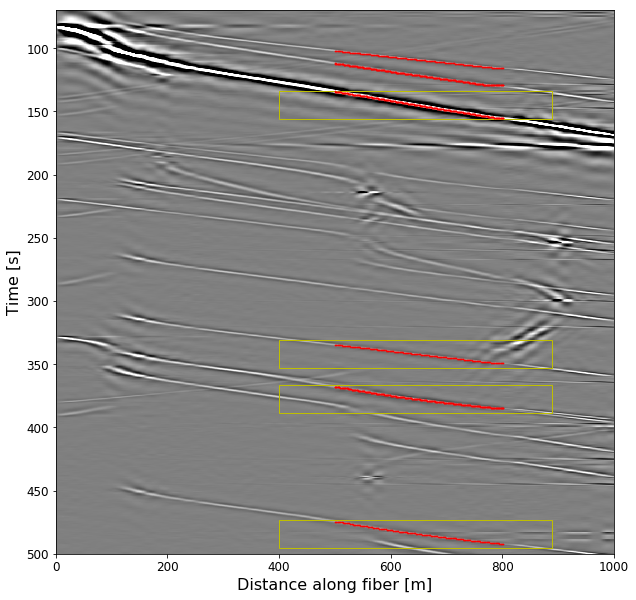

In [3]:
# Take one 10-min data as example
data, x_axis, t_axis = io[13]
# define the spatial window for vehicle tracking
_x0 = 650
tracking_offset = 150
_start_x = _x0 - tracking_offset
_end_x = _x0 + tracking_offset
# Create the Time-Lapse imaging task
imagingObj = TimeLapseImaging(data, x_axis, t_axis, method='xcorr')
# Run the car tracking module
imagingObj.track_cars(start_x=_start_x, end_x=_end_x, show_plot=False, tracking_args=tracking_args)
# Select isolated surface wave (due to car motion) windows
imagingObj.select_surface_wave_windows(x0=_x0, wlen_sw=22, length_sw=500, spatial_ratio=0.5, temporal_spacing=25)
# Visualize car tracking and the selected surface wave windows
imagingObj.visualize_tracking(plt_tlim=500, t_min=70, plt_xlim=1000, fig_dir=None, fig_name=None)

Closed look of one surface-wave window:

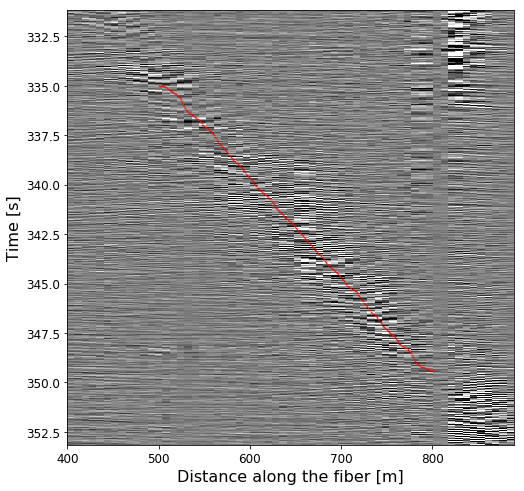

In [4]:
window = imagingObj.sw_selector[1]
window.save_fig()

## 2.3 Cross-Correlation

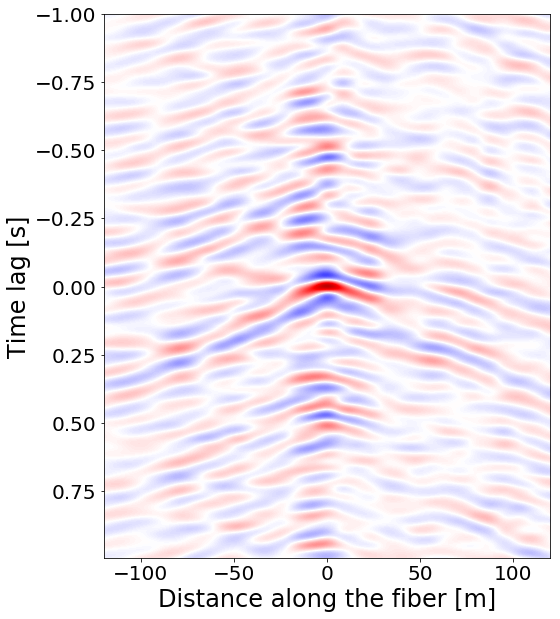

In [5]:
# virtual shot gathers obtained using the forwardpropagating
XCF_out, XCF_x_axis, XCF_t_axis = construct_shot_gather(window, pivot=_x0, start_x=_start_x, 
                                                end_x=_end_x, norm=False, time_window_to_xcorr=4)
plot_xcorr(XCF_out, XCF_t_axis, XCF_x_axis, figsize=(8,10))

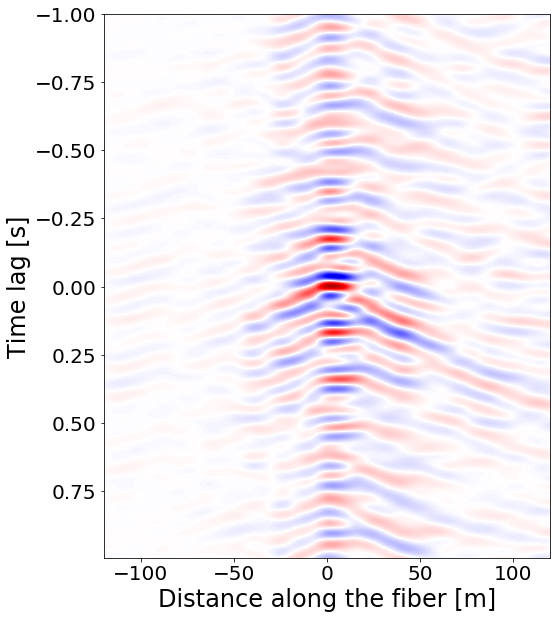

In [6]:
# virtual shot gathers obtained using the backwardpropagating
XCF_out_other_side, XCF_x_axis, XCF_t_axis = construct_shot_gather_other_side(window, pivot=_x0, start_x=_start_x,
                                                                      end_x=_end_x, norm=False, time_window_to_xcorr=4)
plot_xcorr(XCF_out_other_side, XCF_t_axis, XCF_x_axis,  figsize=(8,10))

./figures/shot_gather_one.png has saved...


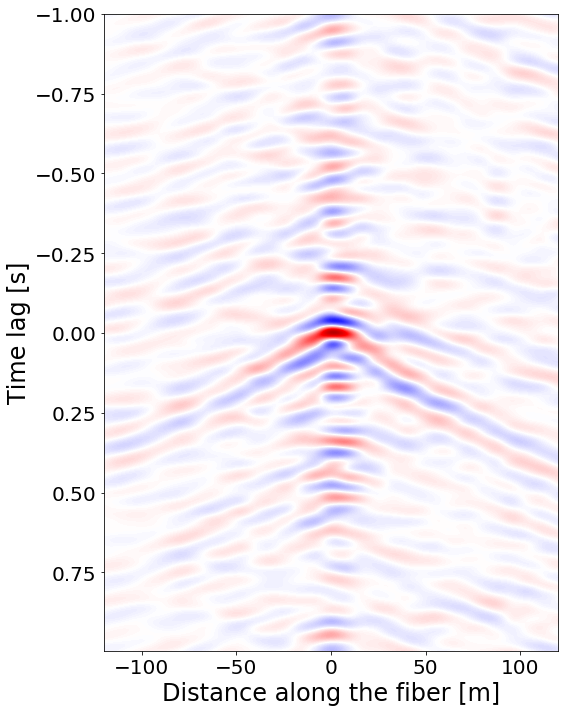

In [7]:
# Combining the forward and backward propagating virtual shot gathers
XCF_out_combined = XCF_out_other_side + XCF_out
plot_xcorr(XCF_out_combined, XCF_t_axis, XCF_x_axis, figsize=(8,10), fig_dir='./figures/', fig_name='shot_gather_one.png')

## 2.3 Dispersion image

None


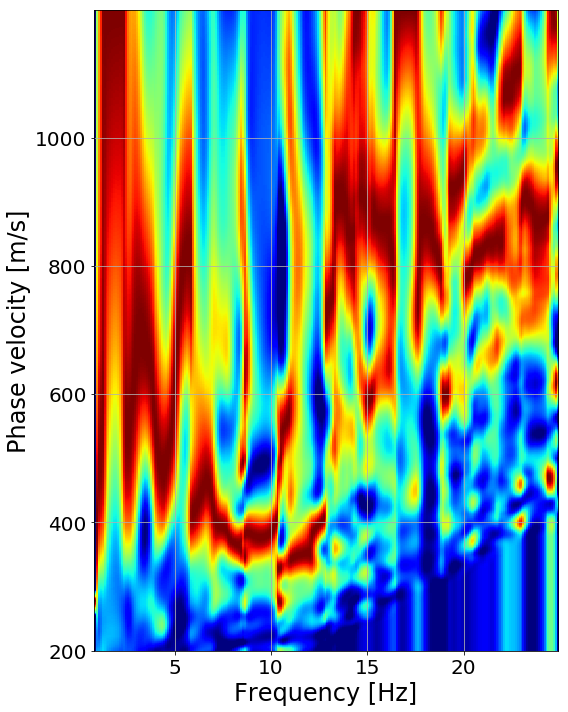

In [8]:
disp = Dispersion(XCF_out_combined, XCF_x_axis[1] - XCF_x_axis[0], XCF_t_axis[1] - XCF_t_axis[0],
                  freqs = np.arange(0.8, 25, 0.1), 
                  vels= np.arange(200, 1200), norm=False)
# disp.plot_image(fig_dir='./figures/', fig_name='dispersion_one.png',end_x=0, start_x=-150)
disp.plot_image(end_x=0, start_x=-150)

# 3. Stacking the virtual shot gathers in one day
Repeat the workflow mentioned in section 2 using one day data and stack the virtual shot gathers due to multiple cars to imporve the SNR.

In [9]:
workflow = ImagingWorkflowOneDirectory('20221223/', root = _root, method='xcorr', tracking_args=tracking_args)
workflow.imaging(start_x=_start_x, end_x=_end_x, x0=_x0, 
                 wlen_sw=22, length_sw=500, spatial_ratio=0.5, 
                 num_to_stop=None, temporal_spacing=12,verbal=False,
                 imaging_kwargs={"pivot": _x0, "start_x": _start_x, 
                                 "end_x": _end_x, "wlen": 2,
                                 "include_other_side": True})

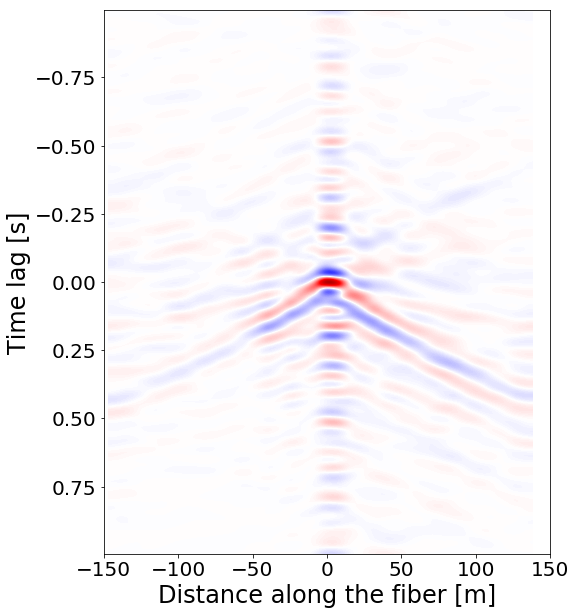

None


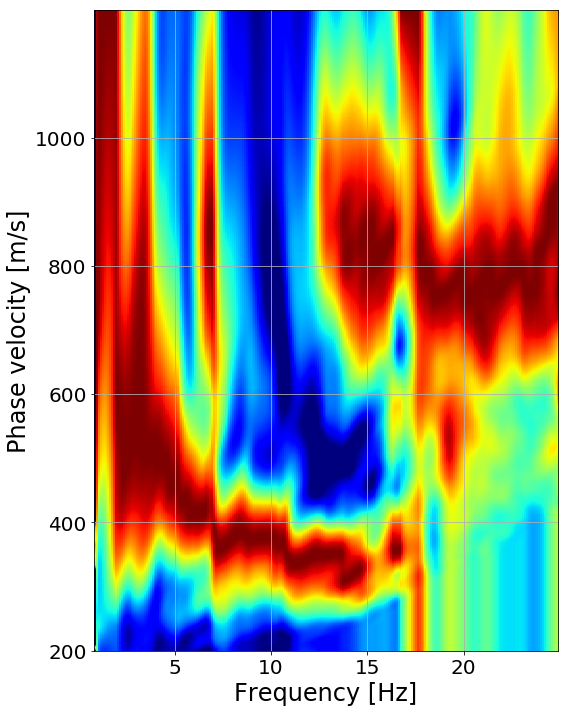

In [10]:
# Virtual shot gathers
workflow.avg_image.plot_image(norm=True, x_lim=[-150, 150])
# Dispersion image
workflow.avg_image.compute_disp_image(end_x=0, start_x=-150)
workflow.avg_image.plot_disp()